# Auto Encoder

L'objectif de ce TP est de classifier des images de MNIST (Modified National Institute of Standards and Technology) database en dix sets( de 0 à 9), en utilisant un algorithme de auto-encoder du package Torch.

In [1]:
from __future__ import print_function

%config IPCompleter.greedy=True

import argparse, torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

batchsize = 128
epochs = 10
loginterval = 10
cuda = torch.cuda.is_available()

SEED = 1
torch.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batchsize, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/data', train=False, transform=transforms.ToTensor()),
    batch_size=batchsize, shuffle=True, **kwargs)

Processing...
Done!


# Model

In [2]:
class AE(nn.Module):
    """
    Auto Encoder model, with one hidden layer.
    
    Attributes
    ----------
    encoder : torch.nn.modules.linear.Sequential
        The first fully-connected layer.
    decoder : torch.nn.modules.linear.Sequential
        The second fully connected layer.
    
    """
    def __init__(self):
        
        #Creation of the model.      
        super(AE, self).__init__()
        # encoder :FC (784 -> 400), RELU activation; FC (400, 20)
        self.encoder = nn.Sequential(nn.Linear(784, 400), nn.ReLU(), nn.Linear(400, 20))
        # decoder :FC (20 -> 400), RELU activation; FC (400, 784)
        self.decoder = nn.Sequential(nn.Linear(20, 400), nn.ReLU(), nn.Linear(400, 784))

    def encode(self, x):
        """
        The encode pass.
        """
        return self.encoder(x)

    def decode(self, z):
        """
        The decode pass.
        
        """
        return torch.sigmoid(self.decoder(z))

    def forward(self, x):
        """
        The forward pass of the global network.
        
        """
        xview = x.view(-1,28*28)
        z = self.encode(xview)
        return self.decode(z)


model = AE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Loss function

In [3]:
def loss_function(recon_batch, x):
    """
    Compute the bce as the binary-cross entropy across the batch as a sum.    
    """
    loss = nn.BCELoss(reduction='sum')
    bce = loss(recon_batch, x)
    return bce

# Train

In [4]:
losses = []
def train(epoch):
    """
    The train phase of the model.
    """
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = loss_function(recon_batch, data.view(-1, 784))
        losses.append(loss.cpu().item())
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % loginterval == 0:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.1f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)), end='')

    print(' Average loss: {:.1f}'.format(
          train_loss / len(train_loader.dataset)), end='')

# Test

In [5]:
def test(epoch):
    """
    The test phase of the model.
    """
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_loss += loss_function(recon_batch, data.view(-1, 784))

            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batchsize, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'resultsAE/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print(' Test loss: {:.1f}'.format(test_loss))

In [6]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
     sample = torch.randn(64, 20).to(device)
     sample = model.decode(sample).cpu()
     save_image(sample.view(64, 1, 28, 28), 'resultsAE/sample_' + str(epoch) + '.png')

 Train Epoch: 1 [58880/60000 (98%)]	Loss: 90.79 Average loss: 132.0 Test loss: 89.0
 Train Epoch: 2 [58880/60000 (98%)]	Loss: 84.4 Average loss: 83.4 Test loss: 78.1
 Train Epoch: 3 [58880/60000 (98%)]	Loss: 76.9 Average loss: 77.0 Test loss: 74.5
 Train Epoch: 4 [58880/60000 (98%)]	Loss: 76.2 Average loss: 74.2 Test loss: 72.6
 Train Epoch: 5 [58880/60000 (98%)]	Loss: 73.4 Average loss: 72.4 Test loss: 71.4
 Train Epoch: 6 [58880/60000 (98%)]	Loss: 69.6 Average loss: 71.1 Test loss: 70.2
 Train Epoch: 7 [58880/60000 (98%)]	Loss: 69.8 Average loss: 70.2 Test loss: 69.5
 Train Epoch: 8 [58880/60000 (98%)]	Loss: 71.2 Average loss: 69.4 Test loss: 68.8
 Train Epoch: 9 [58880/60000 (98%)]	Loss: 68.4 Average loss: 68.8 Test loss: 68.5
 Train Epoch: 10 [58880/60000 (98%)]	Loss: 69.2 Average loss: 68.3 Test loss: 68.1


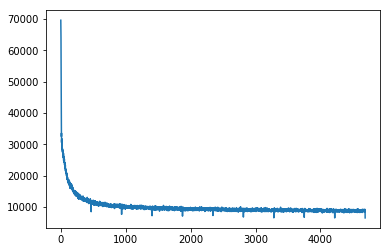

In [7]:
plt.plot(losses)